In [15]:
import numpy as np
import pandas as pd
from numpy import dot
import seaborn as sns
from scipy import stats
import matplotlib as mpl
import scipy.linalg as la
import matplotlib.cm as cm
from numpy.linalg import norm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.linear_model import LinearRegression

# ComputePCs(X) computes principal components from bulk gene expression matrix whose columns are genes 
# and rows are patients (in a DataFrame table), and returns the first k principal components retaining 
# 95% of variation in X
def ComputePCs(X):
    cov=X.dot(X.T)
    w, v = la.eig(cov)
    idx = np.argsort(w)[::-1][:len(w)]
    w = w[idx]
    v = v[:,idx]
    for i in range(len(w)):
        if 100*sum(w[0:i+1].real)/sum(w.real)>95:
            n=i+1
            break
    pc_name=[]
    for i in range(1,n+1):
        pc_name.append('PC'+str(i))
    return pd.DataFrame(v[:,0:n].real, columns=pc_name, index=X.index)
    
# ComputeEigenGene(PCs, y) computes Eigen-Gene from a matrix for the first principal components PCs 
# and phenotype vector y matched actoss patients with PCs's rows, 
# and returns Eigen-Gene, a vector across patients
def ComputeEigenGene(PCs, y):
    reg = LinearRegression().fit(PCs, y)
    reg.score(PCs, y)
    alp=pd.DataFrame(reg.coef_.T, columns=['Eigen-Gene'], index=PCs.columns)
    EigenG=PCs.dot(alp).sort_values(by=['Eigen-Gene'], ascending=True)
    return stats.zscore(EigenG, axis=0)
    
# ComputeEigenPatient(X, EigenG) computes Eigen-Patient by transforming Eigen-Gene 
# under bulk gene expression matrix, and returns Eigen-Patient, a vector over genes 
def ComputeEigenPatient(X, EigenG): 
    EigenP=pd.DataFrame((X.T).dot(EigenG)).rename(columns={'Eigen-Gene':'Eigen-Patient'})
    EigenP=EigenP.sort_values(by=['Eigen-Patient'], ascending=True)
    return stats.zscore(EigenP, axis=0)
    
# PlotPrediction(xloc,yloc, Cosine) plots a scatter plot to show phenotype 
# assignments in spatial locations where xloc and yloc are the spot locations in the tissue slice, 
# Cosine is the similarity between Eigen-Patient and Gene expression in spots of tissue slice, 
# and returns a figure showing the phenotype assignments in the tissue  
def PlotPrediction(xloc,yloc, Cosine):
    fig, ax = plt.subplots(figsize=(5, 4))
    vmin, vmax = Cosine.min(), Cosine.max()
    normalize = mcolors.TwoSlopeNorm(vcenter=vmin+(vmax-vmin)*2/4, vmin=vmin, vmax=vmax)   
    DotSize=10           # change the size of dots depending on resolution of SRT data and figure size
    orig_map = cm.RdYlBu
    reversed_map = orig_map.reversed() 
    s=sns.scatterplot(y=yloc, x=xloc, c=Cosine, norm=normalize, cmap=reversed_map, ax=ax,
                      marker = 'h', s=DotSize, edgecolor = 'none')
    fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin, vmax), cmap=reversed_map),
             ax=ax, orientation='vertical')
    s.set(xticklabels=[]); s.set(yticklabels=[])
    s.set(xlabel=None); s.set(ylabel=None)
    sns.set(font_scale=1, style='white') # change the font size depending on figure size
    plt.savefig('Prediction-Plot.png', dpi=300,  bbox_inches = 'tight')

In [17]:
# Estimation of Eigen-Patient from bulk data of cancer patients
BulkExpression=pd.read_csv('Cancer-Bulk-ExprData.csv', index_col=0)    # Load the bulk gene expression data 
PhenotypeVector = pd.read_csv('Cancer-Phenotype.csv', index_col=0) # Load the vector of phenotype quantity
index=(BulkExpression.index).intersection(PhenotypeVector.index)
BulkExpression=BulkExpression.loc[index]
PhenotypeVector=PhenotypeVector.loc[index]
PCdata=ComputePCs(BulkExpression)                   # Compute the principal components
EigenGene=ComputeEigenGene(PCdata, PhenotypeVector) # Compute the Eigen-Gene vector
EigenGene.to_csv('Eigen-Gene.csv')                  # Save Eigen-Gene vector as a cvs file
EigenPatient=ComputeEigenPatient(BulkExpression, EigenGene) # Compute the Eigen-Patient vector
EigenPatient.to_csv('Eigen-Patient.csv')            # Save Eigen-Gene vector as a cvs file

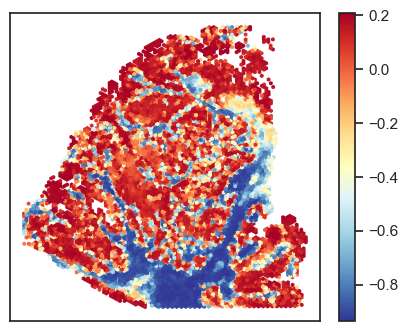

In [19]:
# Prediction of phenotype on spatial locations
DataSRT=pd.read_csv('SRTsample-SRT-ExprData.csv', index_col=0) # SRT gene expression matrix (rows are genes,
                                                              # columns are spots)
index=(DataSRT.index).intersection(EigenPatient.index)
DataSRT=DataSRT.loc[index]
EigenPatient=EigenPatient.loc[index]
n=len(DataSRT.columns)

# Compute cosine similartiy between Eigen-Patient and gene expression in each spot
Cosine=pd.DataFrame(np.zeros((n,1)), columns=['Cosine-Similarity'], index=DataSRT.columns)
for i in Cosine.index:
    Cosine.loc[i]=dot(EigenPatient['Eigen-Patient'], DataSRT[i])/(norm(EigenPatient['Eigen-Patient'])*norm(DataSRT[i]))  

MetaData = pd.read_csv('SRTsample-SRT-spot-locations.csv', index_col=0) # Load spot locations in SRT data
index=(Cosine.index).intersection(MetaData.index)
MetaData=MetaData.loc[index]
Cosine=Cosine.loc[index]
Result=pd.concat([MetaData[['pxl_row_in_fullres', 'pxl_col_in_fullres']], Cosine], axis=1)
x=Result['pxl_row_in_fullres']
y=Result['pxl_col_in_fullres']
Result['Cosine-Similarity'].to_csv('Predicted-Phentype-On-Spots.csv') 
PlotPrediction(x,y, Result['Cosine-Similarity']) # Plot the prediction of phenotype quantity